# Testes e Treinamento

## Prequential Evaluation

AUC: 0.8096822414863241


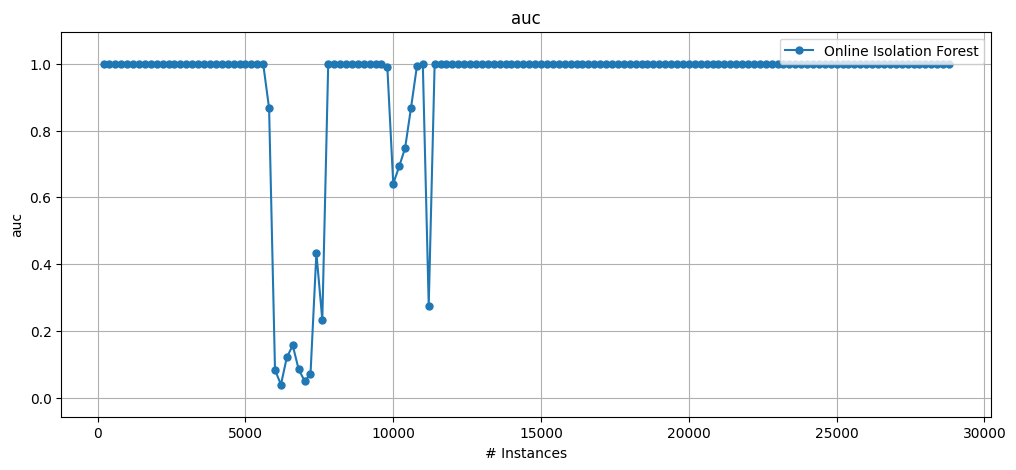

In [5]:
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation_anomaly


oif = OnlineIsolationForest(schema=stream.get_schema())

results_oif = prequential_evaluation_anomaly(
    stream=stream, learner=oif, window_size=200
)

print(f"AUC: {results_oif.auc()}")
# display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## Treinamento e Avaliação

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import AnomalyDetectionEvaluator

def acumulative(WARMUP, stream, window_size=200):
    schema = stream.get_schema()
    learner = OnlineIsolationForest(schema=schema) 
    evaluator = AnomalyDetectionEvaluator(schema)

    history = {
        'instances': [],
        'auc': [],
        'acc': []
    }
    
    attack_regions = []
    in_attack = False
    start_attack = 0

    count = 0
    stream.restart()
    while stream.has_more_instances():
        instance = stream.next_instance()
        is_attack = (instance.y_index == 1) 
        
        if is_attack and not in_attack:
            in_attack = True
            start_attack = count
        elif not is_attack and in_attack:
            in_attack = False
            attack_regions.append((start_attack, count))
        
        if count < WARMUP:
            learner.train(instance)
        else:
            score = learner.score_instance(instance)
            evaluator.update(instance.y_index, score)
            learner.train(instance)

            if count % window_size == 0:
                metrics_dict = evaluator.metrics_dict()
                auc = evaluator.auc()            
                accuracy_score = metrics_dict.get('Accuracy')
                
                history['instances'].append(count)
                history['auc'].append(auc)
                history['acc'].append(accuracy_score)
            
        count += 1
        
    if in_attack:
        attack_regions.append((start_attack, count))

    plt.figure(figsize=(14, 6))
    plt.plot(history['instances'], history['acc'], color='#2ca02c', linewidth=2.0, label='Acurácia')
    plt.plot(history['instances'], history['auc'], color='#1f77b4', linewidth=2.0, label='AUC')
    
    for start, end in attack_regions:
        plt.axvspan(start, end, facecolor='red', alpha=0.15, edgecolor='none', label='Região de Ataque')

    plt.title("Desempenho")
    plt.xlabel("Instâncias")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

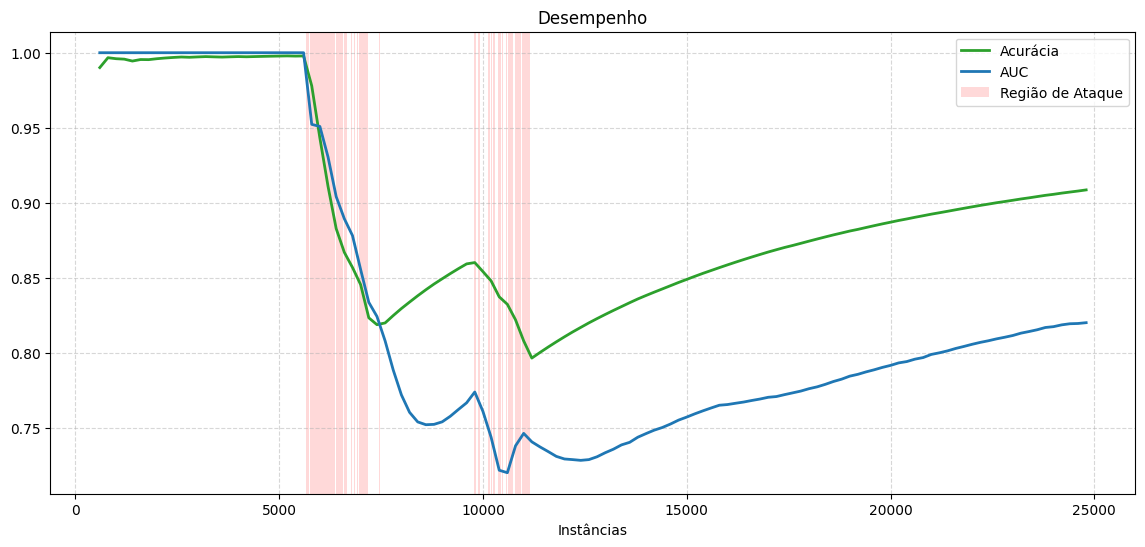

In [62]:
acumulative(WARMUP=500, stream=stream, window_size=200)

## Experimento

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from capymoa.evaluation import AnomalyDetectionEvaluator
from capymoa.drift.detectors import ADWIN
from collections import deque

def plot(results, attack_regions, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
    
    for i, (name, data) in enumerate(results.items()):
        color = colors[i % len(colors)]
        for d_idx, drift_pos in enumerate(data['drifts']):
            ax1.axvline(x=drift_pos, color='black', alpha=0.8, linestyle='-', linewidth=1, zorder=1)
            ax2.axvline(x=drift_pos, color='black', alpha=0.8, linestyle='-', linewidth=1, zorder=1)
            
            if i == 0 and d_idx == 0:
                ax1.plot([], [], color='black', label='Drift Detectado')
                ax2.plot([], [], color='black', label='Drift Detectado')

        ax1.plot(data['instances'], data['auc'], label=f'AUC {name}', color=color, linewidth=2.5, zorder=3)
        ax2.plot(data['instances'], data['acc'], label=f'Acc {name}', color=color, linestyle='--', linewidth=2.5, zorder=3)

    for ax in [ax1, ax2]:
        added_attack_label = False
        for start, end in attack_regions:
            ax.axvspan(start, end, facecolor="#F7C5CD", alpha=0.4, zorder=2,
                       label='Região de Ataque' if not added_attack_label else "")
            added_attack_label = True
            
        ax.legend(loc='best', fontsize=10, frameon=True, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle=':', zorder=0)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax1.set_ylabel("AUC", fontsize=14)
    ax2.set_ylabel("Accuracy", fontsize=14)
    ax2.set_xlabel("Instâncias", fontsize=14)
    ax1.set_ylim(0.0, 1.05) 
    ax2.set_ylim(0.0, 1.05) 
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_score(results, attack_regions, title):
    num_models = len(results)
    fig, axes = plt.subplots(num_models, 1, figsize=(15, 5 * num_models), sharex=True)
    if num_models == 1: axes = [axes]

    for i, (name, data) in enumerate(results.items()):
        ax = axes[i]
        scores = np.array(data['scores'])
        instances = np.arange(len(scores))
        window_size = 30
        moving_avg = np.array([np.mean(scores[max(0, j-window_size):j]) if j > 0 else scores[0] for j in range(len(scores))])
        
        ax.scatter(instances, scores, color="#1f77b4", s=15, alpha=0.4, edgecolors='none', label='Amostra (Score)', zorder=1)
        ax.plot(instances, moving_avg, color="#0400F7", alpha=0.6, linewidth=1.5, label='Média Móvel', zorder=2)

        added_attack_label = False
        for start, end in attack_regions:
            ax.axvspan(start, end, facecolor="#F7C5CD", alpha=0.3, zorder=0,
                       label='Região de Ataque' if not added_attack_label else "")
            added_attack_label = True

        ax.set_title(f"Análise de Scores - {name}", fontsize=12, fontweight='bold')
        ax.set_ylabel("Score de Anomalia", fontsize=14)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.15, linestyle=':')
        ax.set_ylim(0.0, 1.1)

    axes[-1].set_xlabel("Instâncias", fontsize=14)
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

def adaptation(window_scores, beta=0.3, anomaly_threshold=0.6):
    if not window_scores: return False, 0.0
    anomalies = [s for s in window_scores if s > anomaly_threshold]
    anomaly_rate = len(anomalies) / len(window_scores)
    triggered = anomaly_rate > beta
    return triggered, anomaly_rate

def pipeline_1(stream, algorithms, warmup_windows, window_size, title, anomaly_threshold=0.6, beta=0.3, logging=False):
    results = {} 
    attack_regions = []
    warmup_instances = warmup_windows * window_size

    for alg in algorithms:
        stream.restart()
        schema = stream.get_schema()
        learner = alg['class'](schema=schema, **alg.get('params', {}))
        evaluator = AnomalyDetectionEvaluator(schema)
        drift_detector = ADWIN()
        
        history = {'instances': [], 'auc': [], 'acc': [], 'scores': [], 'drifts': []}
        window_instances = []
        window_scores = []
        count = 0
        in_attack, start_attack = False, 0

        while stream.has_more_instances():
            instance = stream.next_instance()
            
            if alg == algorithms[0]:
                is_attack = (instance.y_index == 1)
                if is_attack and not in_attack:
                    in_attack, start_attack = True, count
                elif not is_attack and in_attack:
                    in_attack = False
                    attack_regions.append((start_attack, count))

            score = learner.score_instance(instance) 
            history['scores'].append(score)
            window_scores.append(score)
            window_instances.append(instance)

            # drift_detector.add_element(score)
            # if drift_detector.detected_change():
            #     history['drifts'].append(count)

            if score < anomaly_threshold:
                try: learner.train(instance)
                except ValueError: pass

            if count > 0 and count % window_size == 0:
                triggered, rate = adaptation(window_scores, beta=beta, anomaly_threshold=anomaly_threshold)
                
                if count <= warmup_instances:
                    for inst in window_instances:
                        try: learner.train(inst)
                        except ValueError: pass
                    status = "TREINO REALIZADO (WARMUP)"
                elif not triggered:
                    for inst in window_instances:
                        try: learner.train(inst)
                        except ValueError: pass
                    status = "TREINO REALIZADO"
                else:
                    history['drifts'].append(count)
                    status = "TREINO BLOQUEADO (JANELA ANÔMALA)"
                
                if logging:
                    print(f"[{alg['name']}] Instância: {count} | {status} | Taxa de Anomalia: {rate:.2%}")
                
                window_scores = []
                window_instances = []
            
            evaluator.update(instance.y_index, score)
            if count % window_size == 0:
                metrics = evaluator.metrics_dict()
                history['instances'].append(count)
                history['auc'].append(evaluator.auc())
                history['acc'].append(metrics.get('Accuracy', 0))
                    
            count += 1
            
        results[alg['name']] = history

    plot(results, attack_regions, title)
    plot_score(results, attack_regions, title)

def pipeline_2(stream, algorithms, window_size, title):
    results = {} 
    attack_regions = []

    for alg in algorithms:
        stream.restart()
        schema = stream.get_schema()
        learner = alg['class'](schema=schema, **alg.get('params', {}))
        evaluator = AnomalyDetectionEvaluator(schema)
        drift_detector = ADWIN()
        
        history = {'instances': [], 'auc': [], 'acc': [], 'scores': [], 'drifts': []}
        count = 0
        in_attack, start_attack = False, 0

        while stream.has_more_instances():
            instance = stream.next_instance()
            
            if alg == algorithms[0]:
                is_attack = (instance.y_index == 1)
                if is_attack and not in_attack:
                    in_attack, start_attack = True, count
                elif not is_attack and in_attack:
                    in_attack = False
                    attack_regions.append((start_attack, count))

            # Predição do Score
            score = learner.score_instance(instance) 
            history['scores'].append(score)

            # Detecção de Drift 
            drift_detector.add_element(score)
            if drift_detector.detected_change():
                history['drifts'].append(count)

            # Treino Integral
            try:
                learner.train(instance)
            except ValueError:
                pass

            # Avaliação Constante
            evaluator.update(instance.y_index, score)
            if count % window_size == 0:
                metrics = evaluator.metrics_dict()
                history['instances'].append(count)
                history['auc'].append(evaluator.auc())
                history['acc'].append(metrics.get('Accuracy', 0))
                    
            count += 1
            
        results[alg['name']] = history

    plot(results, attack_regions, title)
    plot_score(results, attack_regions, title)


def pipeline_3(stream, algorithms, window_size, title, K=500, anomaly_threshold=0.4, logging=False):
    results = {} 
    attack_regions = []

    for alg in algorithms:
        stream.restart()
        schema = stream.get_schema()
        learner = alg['class'](schema=schema, **alg.get('params', {}))
        evaluator = AnomalyDetectionEvaluator(schema)
        drift_detector = ADWIN()
        
        history = {'instances': [], 'auc': [], 'acc': [], 'scores': [], 'drifts': []}
        
        # MEMÓRIA DINÂMICA
        # K define o tamanho da memória de longo prazo
        memory_buffer = deque(maxlen=K)
        total_accepted = 0
        window_accepted = 0
        
        count = 0
        in_attack, start_attack = False, 0

        while stream.has_more_instances():
            instance = stream.next_instance()
            
            if alg == algorithms[0]:
                is_attack = (instance.y_index == 1)
                if is_attack and not in_attack:
                    in_attack, start_attack = True, count
                elif not is_attack and in_attack:
                    in_attack = False
                    attack_regions.append((start_attack, count))

            # Obter score atual
            score = learner.score_instance(instance) 
            history['scores'].append(score)

            # Detecção de Drift Estatístico
            drift_detector.add_element(score)
            if drift_detector.detected_change():
                history['drifts'].append(count)

            # LÓGICA MEMSTREAM: ADMISSÃO SELETIVA NA MEMÓRIA
            should_train = (len(memory_buffer) < K) or (score < anomaly_threshold)

            if should_train:
                memory_buffer.append(instance)
                total_accepted += 1
                window_accepted += 1
                try: 
                    learner.train(instance)
                except ValueError: 
                    pass
            
            # Avaliação Constante
            evaluator.update(instance.y_index, score)
            if count % window_size == 0:
                metrics = evaluator.metrics_dict()
                history['instances'].append(count)
                history['auc'].append(evaluator.auc())
                history['acc'].append(metrics.get('Accuracy', 0))
                
                # Log de status da memória
                if logging:
                    print(f"[{alg['name']}] Instância: {count}")
                    print(f"  > Novas amostras aceitas nesta janela: {window_accepted}")
                    print(f"  > Total histórico aceito: {total_accepted}")
                    print(f"  > Taxa de ocupação da fila: {len(memory_buffer)}/{K}")       
                    print(f"  > Taxa de Aceitação: {(total_accepted/(count+1)):.2%}")
                    
                    if window_accepted > K:
                        print(f"  > AVISO: A memória (K={K}) foi totalmente renovada {window_accepted/K:.1f}x nesta janela.")
                    
                    
                    
            count += 1
            
        results[alg['name']] = history

    plot(results, attack_regions, title)
    plot_score(results, attack_regions, title)
    

def ExecuteExperiments(stream, n_pipeline, algorithms, warmup_windows=5, window_size=200, 
                       anomaly_threshold=0.4, beta=0.3, title="Desempenho dos Algoritmos", logging=False, K_MEM=500):
    if n_pipeline == 1:
        pipeline_1(stream, algorithms, warmup_windows, window_size, 
                   anomaly_threshold=anomaly_threshold, beta=beta, title=title, logging=logging)
    elif n_pipeline == 2:
        pipeline_2(stream, algorithms, window_size, title=title)
    
    elif n_pipeline == 3:
        pipeline_3(stream, algorithms, window_size, title, K=K_MEM, anomaly_threshold=anomaly_threshold, logging=logging)

# Execução e Resultados

## Stream

In [72]:
from py.streams import newStream
import pandas as pd

inicio = 60000
fim = 100000
quantidade = fim - inicio
MAX_INSTANCES = quantidade

# df = pd.read_csv(
#     'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
#     skiprows=range(1, inicio), 
#     nrows=quantidade
# )

# df = pd.read_csv(
#     'datasets/MURILO/syn.csv' 
#     # skiprows=range(1, inicio), 
#     # nrows=quantidade
# )

df = pd.read_csv(
    'datasets/MURILO/http-flood.csv'
)


# df = pd.read_csv(
#     'datasets/MURILO/udp.csv'
# )

stream, target_names, feature_names = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)


Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 156) ---
Variância: 85 features removidas. Restantes: 71
Correlação (>0.95): 32 features redundantes removidas. Restantes: 39
Random Forest: Pular.
Features Finais (39) - ['total_flows', 'total_packets', 'avg_duration', 'avg_packet_size', 'packets_per_flow', 'src_port_entropy', 'dst_port_entropy', 'src_ip_entropy', 'flow_size_entropy', 'unique_src_ips', 'unique_src_as', 'unique_src_geo', 'syn_ack_ratio', 'avg_tcp_duration', 'max_bytes_per_flow', 'packet_rate_std', 'bytes_variance', 'bytes_min', 'bytes_cv', 'bytes_skewness', 'bytes_kurtosis', 'packets_variance', 'packets_min', 'duration_variance', 'duration_std', 'duration_

## Resultados

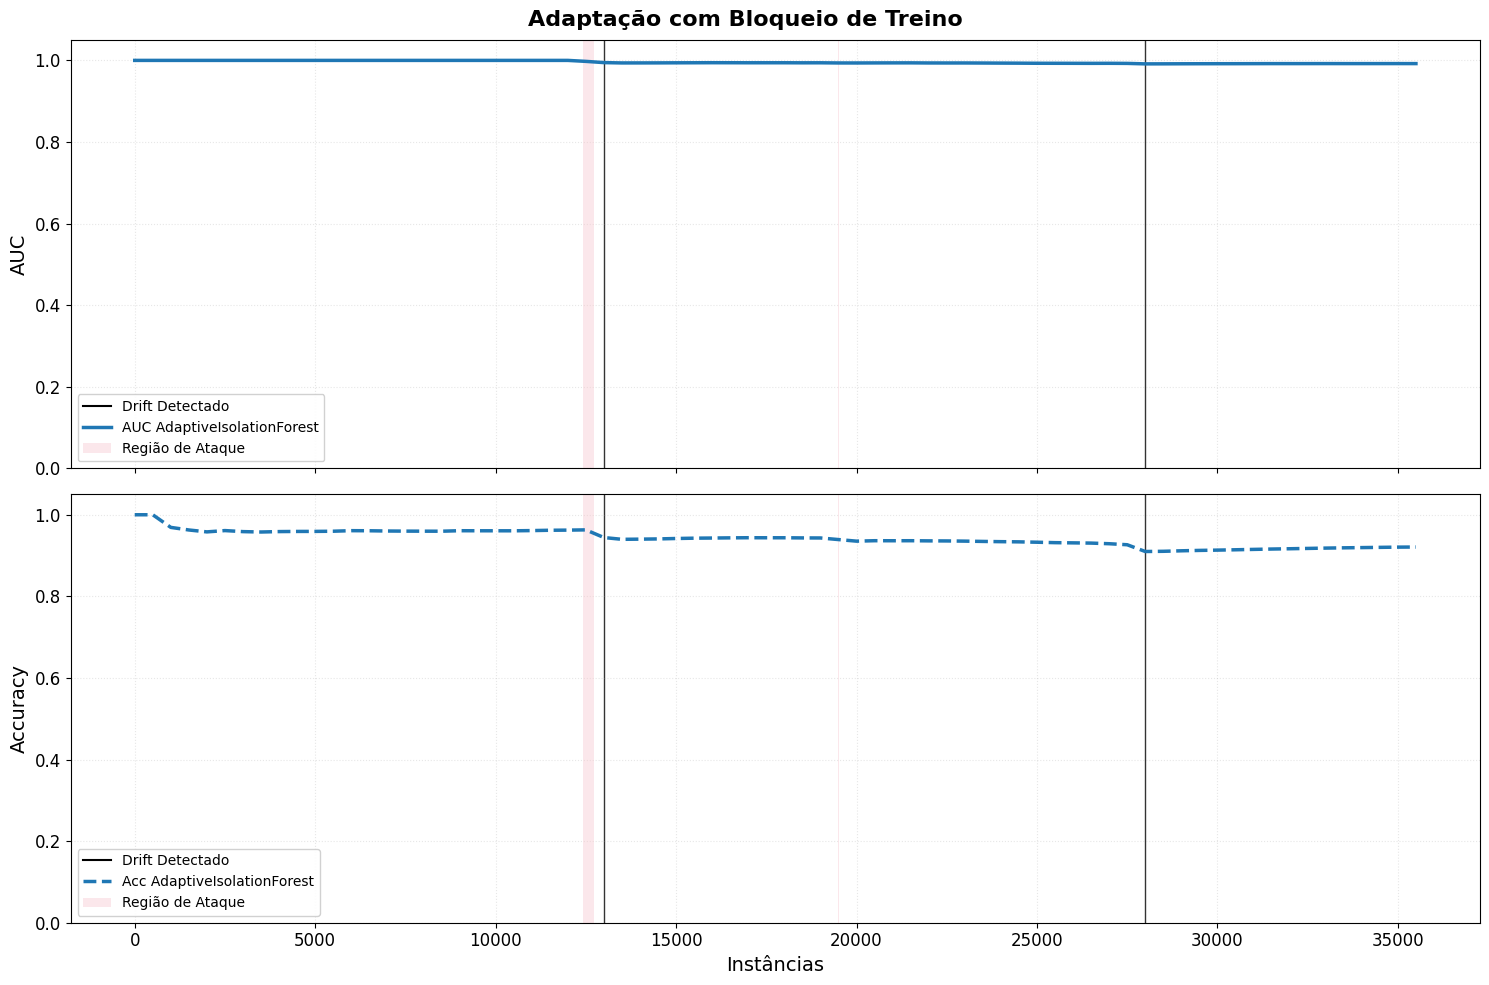

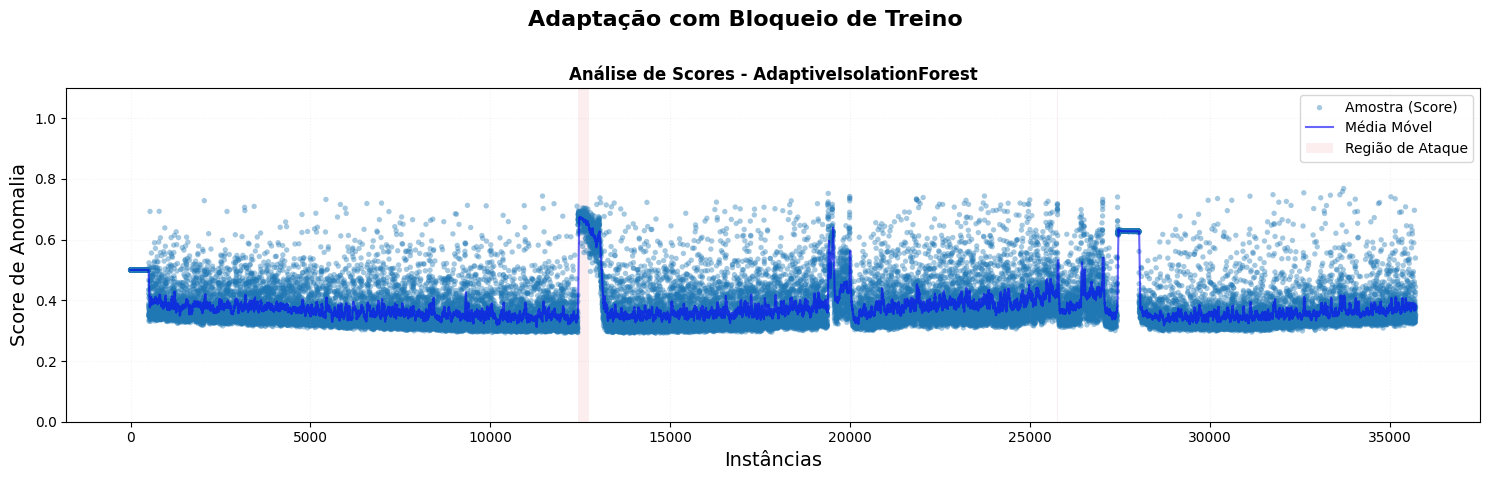

In [73]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.anomaly import OnlineIsolationForest
from capymoa.anomaly import Autoencoder
from capymoa.anomaly import StreamRHF
from capymoa.anomaly import StreamingIsolationForest
from capymoa.anomaly import RobustRandomCutForest
from capymoa.anomaly import AdaptiveIsolationForest

algoritmos = [
    # {'name': 'HalfSpaceTrees', 'class': HalfSpaceTrees, 'params': {}},
    # {'name': 'OnlineIsolationForest', 'class': OnlineIsolationForest, 'params': {}},
    # {'name': 'Autoencoder', 'class': Autoencoder, 'params': {}},
    # {'name': 'StreamRHF', 'class': StreamRHF, 'params': {}}, # DEMORA MUITO
    # {'name': 'StreamingIsolationForest', 'class': StreamingIsolationForest, 'params': {}}, # DEMORA MUITO
    # {'name': 'RobustRandomCutForest', 'class': RobustRandomCutForest, 'params': {}}, # DEMORA MUITO
    {'name': 'AdaptiveIsolationForest', 'class': AdaptiveIsolationForest, 'params': {}},
]

ExecuteExperiments(stream, n_pipeline=1, algorithms=algoritmos, warmup_windows=3, window_size=500, 
        anomaly_threshold=0.5, beta=0.3, title="Adaptação com Bloqueio de Treino", logging=False)

# ExecuteExperiments(stream, n_pipeline=2, algorithms=algoritmos, 
#                    window_size=500, title="Treino Integral")

# ExecuteExperiments(stream, n_pipeline=3, algorithms=algoritmos, 
#                    window_size=500, title="Treino MemStream - Memória de Longo Prazo", 
#                    K_MEM=500, anomaly_threshold=0.4, logging=False)
